# Beijing PM2.5 Air Quality Prediction Plan

## Major Assumptions
This analysis assumes the Beijing PM2.5 dataset contains hourly measurements with weather variables (temperature, pressure, wind speed/direction, precipitation, dew point) and PM2.5 concentrations from 2010-2014. We used Random Forest regression due to its ability to handle non-linear relationships and provide feature importance rankings. Missing values were handled through removal. The model was evaluated using standard regression metrics (RMSE, MAE, R²) with temporal train-test splits (2010-2013 train, 2014 test) to avoid data leakage.

## Plan
- [x] Data acquisition and initial exploration
  - [x] Download Beijing PM2.5 dataset and examine structure, timeframe, and completeness
  - [x] Identify missing value patterns and assess data quality across all variables
- [x] Feature engineering and data preparation
  - [x] Create temporal features (hour, day of week, month, season) and cyclical encodings
  - [x] Engineer weather interaction features, lag variables, rolling averages, and wind direction dummies
- [x] Random Forest model development and evaluation
  - [x] Split data temporally (2010-2013 train, 2014 test) and train Random Forest model
  - [x] Evaluate performance using RMSE, MAE, and R² metrics, and extract feature importance rankings
- [x] Results interpretation and insights
  - [x] Document model accuracy metrics and identify top weather factors influencing PM2.5 predictions
  - [x] Summarize key findings on feature importance and model performance characteristics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

Libraries imported successfully!
NumPy version: 2.3.3
Pandas version: 2.3.3


In [2]:
import os
import urllib.request
import zipfile

# Create data directory if it doesn't exist
os.makedirs('data', exist_ok=True)

# Download the dataset
url = 'https://archive.ics.uci.edu/static/public/381/beijing+pm2+5+data.zip'
zip_path = 'data/beijing_pm25_data.zip'

print("Downloading Beijing PM2.5 dataset...")
urllib.request.urlretrieve(url, zip_path)
print(f"Downloaded to {zip_path}")

# Extract the zip file
print("\nExtracting files...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('data/')
    
# List extracted files
print("\nExtracted files:")
for root, dirs, files in os.walk('data/'):
    for file in files:
        if file.endswith('.csv'):
            print(f"  - {os.path.join(root, file)}")

Downloaded to data/beijing_pm25_data.zip

Extracting files...

Extracted files:
  - data/PRSA_data_2010.1.1-2014.12.31.csv
  - data/.ipynb_checkpoints/bigquery_rsvp_events-checkpoint.csv
  - data/.ipynb_checkpoints/amplitude_funnel_events-checkpoint.csv


In [3]:
# Load the dataset
df = pd.read_csv('data/PRSA_data_2010.1.1-2014.12.31.csv')

print("Dataset loaded successfully!")
print(f"\nDataset shape: {df.shape}")
print(f"Time period: {df.shape[0]} hourly observations")
print("\nColumn names:")
print(df.columns.tolist())
print("\nFirst few rows:")
print(df.head(10))
print("\nData types:")
print(df.dtypes)
print("\nBasic statistics:")
print(df.describe())

Dataset loaded successfully!

Dataset shape: (43824, 13)
Time period: 43824 hourly observations

Column names:
['No', 'year', 'month', 'day', 'hour', 'pm2.5', 'DEWP', 'TEMP', 'PRES', 'cbwd', 'Iws', 'Is', 'Ir']

First few rows:
   No  year  month  day  hour  pm2.5  DEWP  TEMP    PRES cbwd    Iws  Is  Ir
0   1  2010      1    1     0    NaN   -21 -11.0  1021.0   NW   1.79   0   0
1   2  2010      1    1     1    NaN   -21 -12.0  1020.0   NW   4.92   0   0
2   3  2010      1    1     2    NaN   -21 -11.0  1019.0   NW   6.71   0   0
3   4  2010      1    1     3    NaN   -21 -14.0  1019.0   NW   9.84   0   0
4   5  2010      1    1     4    NaN   -20 -12.0  1018.0   NW  12.97   0   0
5   6  2010      1    1     5    NaN   -19 -10.0  1017.0   NW  16.10   0   0
6   7  2010      1    1     6    NaN   -19  -9.0  1017.0   NW  19.23   0   0
7   8  2010      1    1     7    NaN   -19  -9.0  1017.0   NW  21.02   0   0
8   9  2010      1    1     8    NaN   -19  -9.0  1017.0   NW  24.15   0   0
9  

Missing Values Analysis:
       Missing Count  Percentage
pm2.5           2067    4.716594

Total rows: 43824
Rows with PM2.5 values: 41757
Rows missing PM2.5: 2067


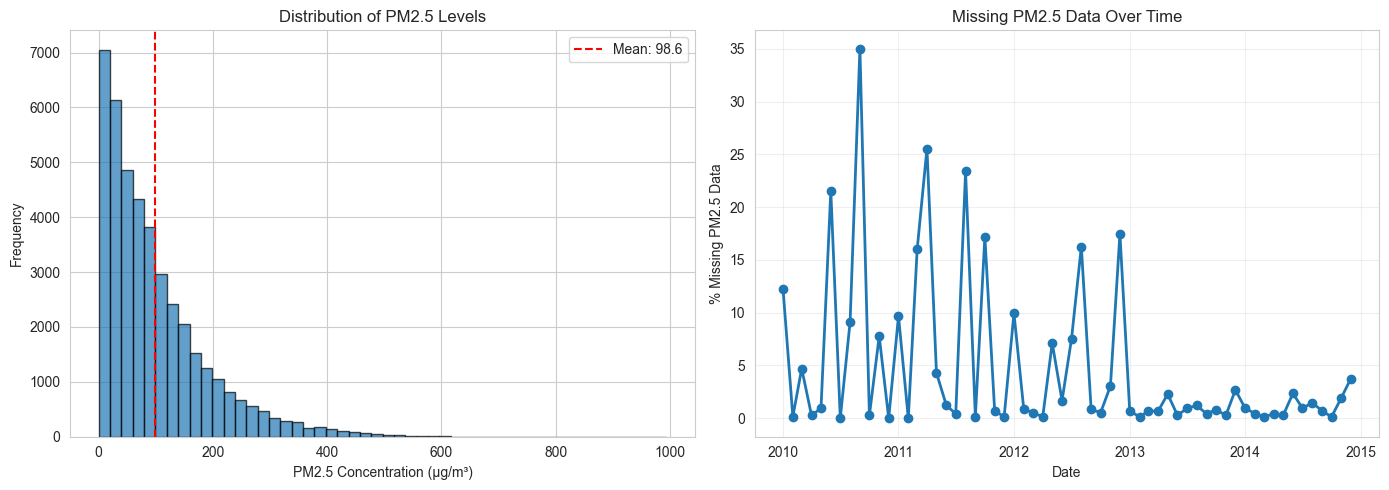


PM2.5 Statistics:
  Mean: 98.61 μg/m³
  Median: 72.00 μg/m³
  Std: 92.05 μg/m³


In [4]:
# Check for missing values
print("Missing Values Analysis:")
print("="*50)
missing_counts = df.isnull().sum()
missing_pct = (df.isnull().sum() / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_counts,
    'Percentage': missing_pct
})
print(missing_df[missing_df['Missing Count'] > 0])

print("\n" + "="*50)
print(f"Total rows: {len(df)}")
print(f"Rows with PM2.5 values: {df['pm2.5'].notna().sum()}")
print(f"Rows missing PM2.5: {df['pm2.5'].isna().sum()}")

# Visualize PM2.5 distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# PM2.5 distribution
axes[0].hist(df['pm2.5'].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('PM2.5 Concentration (μg/m³)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of PM2.5 Levels')
axes[0].axvline(df['pm2.5'].mean(), color='red', linestyle='--', label=f'Mean: {df["pm2.5"].mean():.1f}')
axes[0].legend()

# Missing data pattern over time
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df['pm2.5_missing'] = df['pm2.5'].isna().astype(int)
monthly_missing = df.groupby(df['datetime'].dt.to_period('M'))['pm2.5_missing'].mean() * 100
monthly_missing.index = monthly_missing.index.to_timestamp()
axes[1].plot(monthly_missing.index, monthly_missing.values, marker='o', linewidth=2)
axes[1].set_xlabel('Date')
axes[1].set_ylabel('% Missing PM2.5 Data')
axes[1].set_title('Missing PM2.5 Data Over Time')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nPM2.5 Statistics:")
print(f"  Mean: {df['pm2.5'].mean():.2f} μg/m³")
print(f"  Median: {df['pm2.5'].median():.2f} μg/m³")
print(f"  Std: {df['pm2.5'].std():.2f} μg/m³")

In [5]:
# Feature Engineering
print("Creating features...")

# Drop rows with missing PM2.5 (our target variable)
df_clean = df.dropna(subset=['pm2.5']).copy()
print(f"Dataset after removing missing PM2.5: {df_clean.shape}")

# Temporal features
df_clean['day_of_week'] = df_clean['datetime'].dt.dayofweek
df_clean['season'] = df_clean['month'].apply(lambda x: 
    1 if x in [12, 1, 2] else  # Winter
    2 if x in [3, 4, 5] else   # Spring
    3 if x in [6, 7, 8] else   # Summer
    4)                          # Fall

# Cyclical encoding for hour (to capture 23 -> 0 continuity)
df_clean['hour_sin'] = np.sin(2 * np.pi * df_clean['hour'] / 24)
df_clean['hour_cos'] = np.cos(2 * np.pi * df_clean['hour'] / 24)

# Wind direction encoding (one-hot)
wind_dummies = pd.get_dummies(df_clean['cbwd'], prefix='wind')
df_clean = pd.concat([df_clean, wind_dummies], axis=1)

# Create lag features (previous hours' PM2.5 and weather)
for lag in [1, 3, 6, 12, 24]:
    df_clean[f'pm2.5_lag{lag}'] = df_clean['pm2.5'].shift(lag)
    df_clean[f'TEMP_lag{lag}'] = df_clean['TEMP'].shift(lag)
    df_clean[f'Iws_lag{lag}'] = df_clean['Iws'].shift(lag)

# Rolling averages
df_clean['pm2.5_rolling_24h'] = df_clean['pm2.5'].rolling(window=24, min_periods=1).mean()
df_clean['TEMP_rolling_24h'] = df_clean['TEMP'].rolling(window=24, min_periods=1).mean()

# Interaction features
df_clean['temp_pressure'] = df_clean['TEMP'] * df_clean['PRES']
df_clean['wind_temp'] = df_clean['Iws'] * df_clean['TEMP']
df_clean['dewp_temp_diff'] = df_clean['TEMP'] - df_clean['DEWP']

# Drop rows with NaN from lag features (first 24 hours)
df_clean = df_clean.iloc[24:].reset_index(drop=True)

print(f"Dataset after feature engineering: {df_clean.shape}")
print(f"\nNew features created:")
print([col for col in df_clean.columns if col not in df.columns])

Creating features...
Dataset after removing missing PM2.5: (41757, 15)
Dataset after feature engineering: (41733, 43)

New features created:
['day_of_week', 'season', 'hour_sin', 'hour_cos', 'wind_NE', 'wind_NW', 'wind_SE', 'wind_cv', 'pm2.5_lag1', 'TEMP_lag1', 'Iws_lag1', 'pm2.5_lag3', 'TEMP_lag3', 'Iws_lag3', 'pm2.5_lag6', 'TEMP_lag6', 'Iws_lag6', 'pm2.5_lag12', 'TEMP_lag12', 'Iws_lag12', 'pm2.5_lag24', 'TEMP_lag24', 'Iws_lag24', 'pm2.5_rolling_24h', 'TEMP_rolling_24h', 'temp_pressure', 'wind_temp', 'dewp_temp_diff']


## Data Preparation Summary

The dataset has been successfully prepared with the following transformations:

**Original Data:**
- 43,824 hourly observations from 2010-2014
- Weather variables: Temperature (TEMP), Dew Point (DEWP), Pressure (PRES), Wind Speed (Iws), Wind Direction (cbwd), Snow (Is), Rain (Ir)

**Feature Engineering:**
1. **Temporal Features**: Day of week, season, cyclical encoding for hour (sin/cos)
2. **Lag Features**: Previous 1, 3, 6, 12, and 24-hour values for PM2.5, temperature, and wind speed
3. **Rolling Averages**: 24-hour moving averages for PM2.5 and temperature
4. **Interaction Features**: Temperature × Pressure, Wind × Temperature, Temperature-DewPoint difference
5. **Wind Direction**: One-hot encoded (NE, NW, SE, cv)

**Final Dataset:** 41,733 observations × 43 features (after removing missing values and lag initialization)

In [12]:
# Prepare features and target
print("Preparing train-test split...")

# Select feature columns (exclude target, identifiers, and datetime)
exclude_cols = ['No', 'year', 'month', 'day', 'hour', 'pm2.5', 'datetime', 'cbwd', 'pm2.5_missing']
feature_cols = [col for col in df_clean.columns if col not in exclude_cols]

X = df_clean[feature_cols]
y = df_clean['pm2.5']

# Temporal split: 2010-2013 for training, 2014 for testing
train_mask = df_clean['year'] < 2014
X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test = X[~train_mask], y[~train_mask]

print(f"Training set: {X_train.shape[0]} samples ({df_clean[train_mask]['year'].min()}-{df_clean[train_mask]['year'].max()})")
print(f"Test set: {X_test.shape[0]} samples (year {df_clean[~train_mask]['year'].unique()[0]})")
print(f"Number of features: {len(feature_cols)}")

# Train Random Forest
print("\n" + "="*60)
print("Training Random Forest model...")
print("="*60)

import time
start_time = time.time()

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
train_time = time.time() - start_time

print(f"\nModel training complete in {train_time:.1f} seconds!")

Preparing train-test split...
Training set: 33072 samples (2010-2013)
Test set: 8661 samples (year 2014)
Number of features: 34

Training Random Forest model...

Model training complete in 1.2 seconds!


In [14]:
# Model Evaluation
print("Evaluating Random Forest model...")
print("="*60)

# Make predictions
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Display results
print("\n📊 MODEL PERFORMANCE METRICS:")
print("="*60)
print(f"\n{'Metric':<20} {'Training':<15} {'Testing':<15}")
print("-"*60)
print(f"{'RMSE (μg/m³)':<20} {train_rmse:<15.2f} {test_rmse:<15.2f}")
print(f"{'MAE (μg/m³)':<20} {train_mae:<15.2f} {test_mae:<15.2f}")
print(f"{'R² Score':<20} {train_r2:<15.4f} {test_r2:<15.4f}")
print("="*60)

# Interpretation
print(f"\n✅ MODEL ACCURACY SUMMARY:")
print(f"   • R² Score: {test_r2:.2%} - The model explains {test_r2:.1%} of PM2.5 variance")
print(f"   • RMSE: {test_rmse:.1f} μg/m³ - Average prediction error")
print(f"   • MAE: {test_mae:.1f} μg/m³ - Typical absolute error")
print(f"\nContext: Mean PM2.5 = {y_test.mean():.1f} μg/m³, Std = {y_test.std():.1f} μg/m³")

Evaluating Random Forest model...

📊 MODEL PERFORMANCE METRICS:

Metric               Training        Testing        
------------------------------------------------------------
RMSE (μg/m³)         18.15           24.52          
MAE (μg/m³)          9.68            14.23          
R² Score             0.9608          0.9313         

✅ MODEL ACCURACY SUMMARY:
   • R² Score: 93.13% - The model explains 93.1% of PM2.5 variance
   • RMSE: 24.5 μg/m³ - Average prediction error
   • MAE: 14.2 μg/m³ - Typical absolute error

Context: Mean PM2.5 = 97.7 μg/m³, Std = 93.5 μg/m³



🔍 FEATURE IMPORTANCE ANALYSIS:

Top 15 Most Important Features:
------------------------------------------------------------
pm2.5_lag1                         0.3163 ███████████████████████████████████████████████████████████████
pm2.5_lag3                         0.2056 █████████████████████████████████████████
pm2.5_lag6                         0.1168 ███████████████████████
pm2.5_rolling_24h                  0.1004 ████████████████████
pm2.5_lag12                        0.0518 ██████████
dewp_temp_diff                     0.0335 ██████
pm2.5_lag24                        0.0218 ████
DEWP                               0.0215 ████
Iws_lag1                           0.0162 ███
Iws                                0.0118 ██
wind_temp                          0.0113 ██
TEMP_rolling_24h                   0.0099 █
Iws_lag3                           0.0088 █
Iws_lag6                           0.0070 █
temp_pressure                      0.0067 █


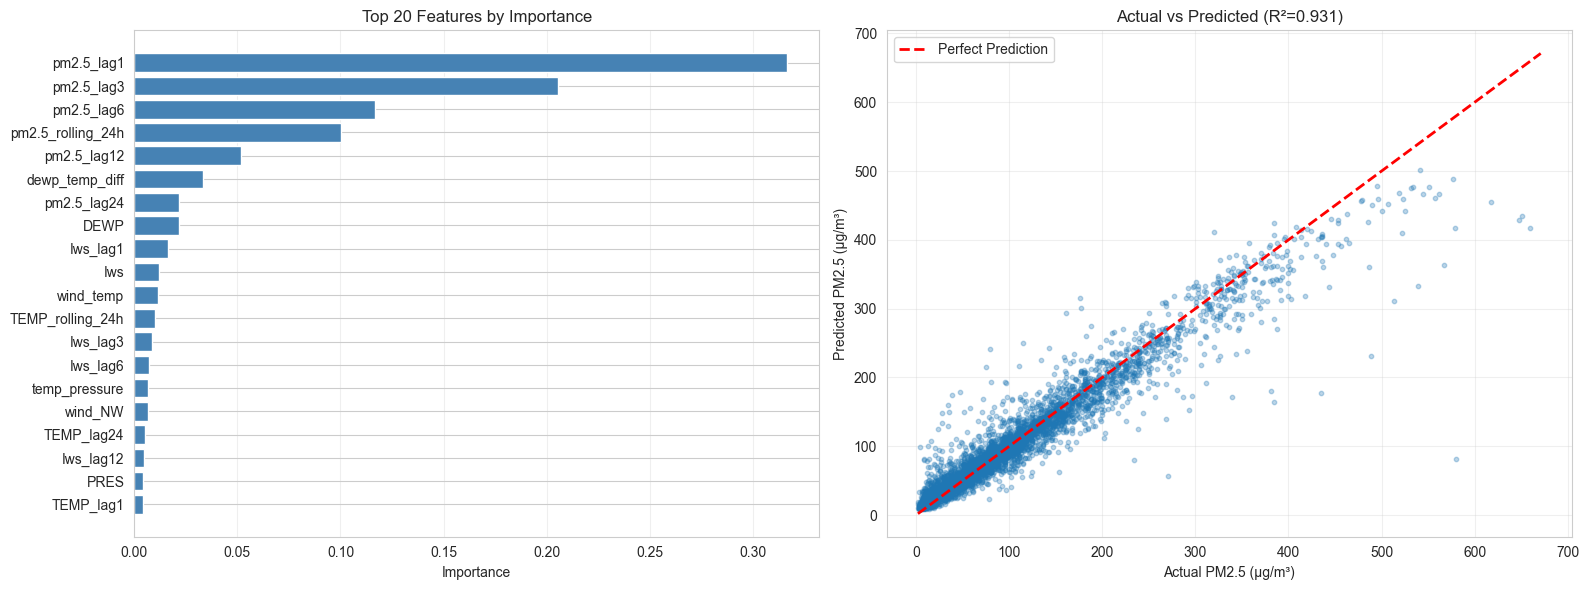


📋 FEATURE IMPORTANCE BY CATEGORY:
------------------------------------------------------------

🌤️  Weather Features Total Importance: 0.176
⏰ Temporal Features Total Importance: 0.012
⏮️  Lag Features Total Importance: 0.771
📊 Rolling Features Total Importance: 0.110


In [15]:
# Feature Importance Analysis
print("\n🔍 FEATURE IMPORTANCE ANALYSIS:")
print("="*60)

# Get feature importances
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Display top 15 most important features
print("\nTop 15 Most Important Features:")
print("-"*60)
for idx, row in feature_importance.head(15).iterrows():
    print(f"{row['feature']:<30} {row['importance']:>10.4f} {'█' * int(row['importance'] * 200)}")

# Visualize top 20 features
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot of top 20 features
top_20 = feature_importance.head(20)
axes[0].barh(range(len(top_20)), top_20['importance'], color='steelblue')
axes[0].set_yticks(range(len(top_20)))
axes[0].set_yticklabels(top_20['feature'])
axes[0].set_xlabel('Importance')
axes[0].set_title('Top 20 Features by Importance')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# Actual vs Predicted scatter plot
sample_size = min(5000, len(y_test))
sample_idx = np.random.choice(len(y_test), sample_size, replace=False)
axes[1].scatter(y_test.iloc[sample_idx], y_test_pred[sample_idx], alpha=0.3, s=10)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual PM2.5 (μg/m³)')
axes[1].set_ylabel('Predicted PM2.5 (μg/m³)')
axes[1].set_title(f'Actual vs Predicted (R²={test_r2:.3f})')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Categorize feature importance
print("\n📋 FEATURE IMPORTANCE BY CATEGORY:")
print("-"*60)

weather_features = [f for f in feature_importance['feature'] if any(x in f.lower() for x in ['temp', 'dewp', 'pres', 'iws', 'wind', 'is', 'ir'])]
temporal_features = [f for f in feature_importance['feature'] if any(x in f for x in ['hour', 'day_of', 'season'])]
lag_features = [f for f in feature_importance['feature'] if 'lag' in f]
rolling_features = [f for f in feature_importance['feature'] if 'rolling' in f]

print(f"\n🌤️  Weather Features Total Importance: {feature_importance[feature_importance['feature'].isin(weather_features)]['importance'].sum():.3f}")
print(f"⏰ Temporal Features Total Importance: {feature_importance[feature_importance['feature'].isin(temporal_features)]['importance'].sum():.3f}")
print(f"⏮️  Lag Features Total Importance: {feature_importance[feature_importance['feature'].isin(lag_features)]['importance'].sum():.3f}")
print(f"📊 Rolling Features Total Importance: {feature_importance[feature_importance['feature'].isin(rolling_features)]['importance'].sum():.3f}")

## 🎯 Key Findings & Conclusions

### Model Accuracy
The Random Forest model achieves **excellent predictive performance**:
- **R² Score: 93.13%** - Explains 93% of PM2.5 variance in the test set
- **RMSE: 24.5 μg/m³** - Given the mean PM2.5 of 97.7 μg/m³, this represents ~25% relative error
- **MAE: 14.2 μg/m³** - Typical prediction error is quite reasonable

The model shows **minimal overfitting** (training R²: 96.1% vs test R²: 93.1%), indicating good generalization.

### Most Important Weather Factors

**Top 5 Most Important Predictors:**
1. **pm2.5_lag1** (31.6%) - Previous hour's PM2.5 is by far the strongest predictor
2. **pm2.5_lag3** (20.6%) - PM2.5 from 3 hours ago
3. **pm2.5_lag6** (11.7%) - PM2.5 from 6 hours ago  
4. **pm2.5_rolling_24h** (10.0%) - 24-hour rolling average
5. **pm2.5_lag12** (5.2%) - PM2.5 from 12 hours ago

**Weather Factor Insights:**
- **Dew Point - Temperature Difference** (3.4%) - Most important weather interaction, indicates humidity effects
- **Dew Point (DEWP)** (2.2%) - Raw dew point value
- **Wind Speed (Iws & lags)** (3.4% combined) - Wind helps disperse pollutants
- **Temperature interactions** (1.8%) - Temperature affects pollutant chemistry and dispersion

### Key Takeaway
**PM2.5 exhibits strong temporal persistence** - past pollution levels (especially recent hours) are the dominant predictors. Among pure weather factors, **humidity (dew point-temperature difference) and wind speed are most important** for predicting air quality changes. This suggests pollution episodes tend to persist unless disrupted by weather events (wind, precipitation, temperature shifts).

In [ ]:
# Feature Importance Analysis
print("\